In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

In [2]:
#Display options
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [3]:
# Load energy data
energy_data = pd.read_csv('data/energy_dataset.csv')

In [4]:
energy_data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [5]:
# Load weather data
weather_data = pd.read_csv('data/weather_features.csv')

In [6]:
weather_data.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [7]:
weather_data.city_name.value_counts()

Madrid        36267
Bilbao        35951
Seville       35557
 Barcelona    35476
Valencia      35145
Name: city_name, dtype: int64

In [8]:
weather_data[weather_data.city_name == "Bilbao"]

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
71412,2015-01-01 00:00:00+01:00,Bilbao,269.657312,269.657312,269.657312,1036,97,0,226,0.0,0.0,0.0,0,800,clear,sky is clear,01
71413,2015-01-01 01:00:00+01:00,Bilbao,269.763500,269.763500,269.763500,1035,97,0,229,0.0,0.0,0.0,0,800,clear,sky is clear,01
71414,2015-01-01 02:00:00+01:00,Bilbao,269.251688,269.251688,269.251688,1036,97,1,224,0.0,0.0,0.0,0,800,clear,sky is clear,01
71415,2015-01-01 03:00:00+01:00,Bilbao,269.203344,269.203344,269.203344,1035,97,1,225,0.0,0.0,0.0,0,800,clear,sky is clear,01
71416,2015-01-01 04:00:00+01:00,Bilbao,269.485500,269.485500,269.485500,1035,97,1,221,0.0,0.0,0.0,0,800,clear,sky is clear,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107358,2018-12-31 19:00:00+01:00,Bilbao,281.260000,280.150000,282.150000,1033,93,0,57,0.0,0.0,0.0,0,800,clear,sky is clear,01n
107359,2018-12-31 20:00:00+01:00,Bilbao,279.810000,278.150000,281.150000,1034,93,1,0,0.0,0.0,0.0,0,800,clear,sky is clear,01n
107360,2018-12-31 21:00:00+01:00,Bilbao,277.150000,277.150000,277.150000,1034,100,1,140,0.0,0.0,0.0,0,800,clear,sky is clear,01n
107361,2018-12-31 22:00:00+01:00,Bilbao,276.600000,276.150000,277.150000,1034,93,1,120,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [9]:
# Display the first few rows of each dataset
energy_data.shape

(35064, 29)

In [10]:
weather_data.shape

(178396, 17)

In [11]:
# Convert the time columns to datetime format again
energy_data['time'] = pd.to_datetime(energy_data['time'], utc=True)
weather_data['time'] = pd.to_datetime(weather_data['dt_iso'], utc=True)

# Merge the two datasets on the 'time' column again
merged_data = pd.merge(energy_data, weather_data, how='inner', on='time')

# Sort the merged data by time
merged_data.sort_values('time', inplace=True)

In [12]:
merged_data.shape

(178396, 46)

In [13]:
merged_data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.1,65.41,2015-01-01 00:00:00+01:00,Valencia,270.475000,270.475000,270.475000,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.1,65.41,2015-01-01 00:00:00+01:00,Madrid,267.325000,267.325000,267.325000,971,63,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.1,65.41,2015-01-01 00:00:00+01:00,Bilbao,269.657312,269.657312,269.657312,1036,97,0,226,0.0,0.0,0.0,0,800,clear,sky is clear,01
3,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.1,65.41,2015-01-01 00:00:00+01:00,Barcelona,281.625000,281.625000,281.625000,1035,100,7,58,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.1,65.41,2015-01-01 00:00:00+01:00,Seville,273.375000,273.375000,273.375000,1039,75,1,21,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [14]:
city_valencia = merged_data[merged_data.city_name == "Valencia"]
city_madrid = merged_data[merged_data.city_name == "Madrid"]
city_bilbao = merged_data[merged_data.city_name == "Bilbao"]
city_barcelona = merged_data[merged_data.city_name == "Barcelona"]
city_seville = merged_data[merged_data.city_name == "Seville"]

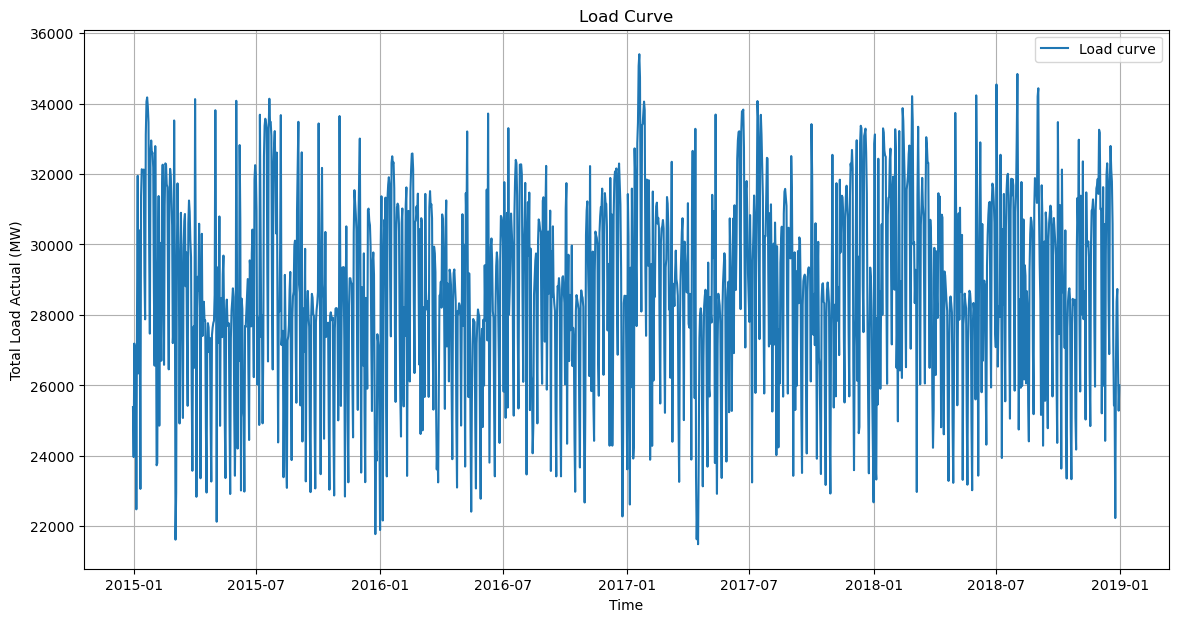

In [15]:
# Create a new DataFrame for plotting
plot_data = merged_data[['time', 'total load actual', 'price actual']].copy()

# Set the time as the index of the DataFrame
plot_data.set_index('time', inplace=True)

# Resample the data to daily averages to simplify the plot
plot_data_daily = plot_data.resample('D').mean()

# Create the load curve plot
plt.figure(figsize=(14, 7))
plt.plot(plot_data_daily.index, plot_data_daily['total load actual'], label='Load curve')
plt.title('Load Curve')
plt.xlabel('Time')
plt.ylabel('Total Load Actual (MW)')
plt.legend()
plt.grid(True)
plt.show()

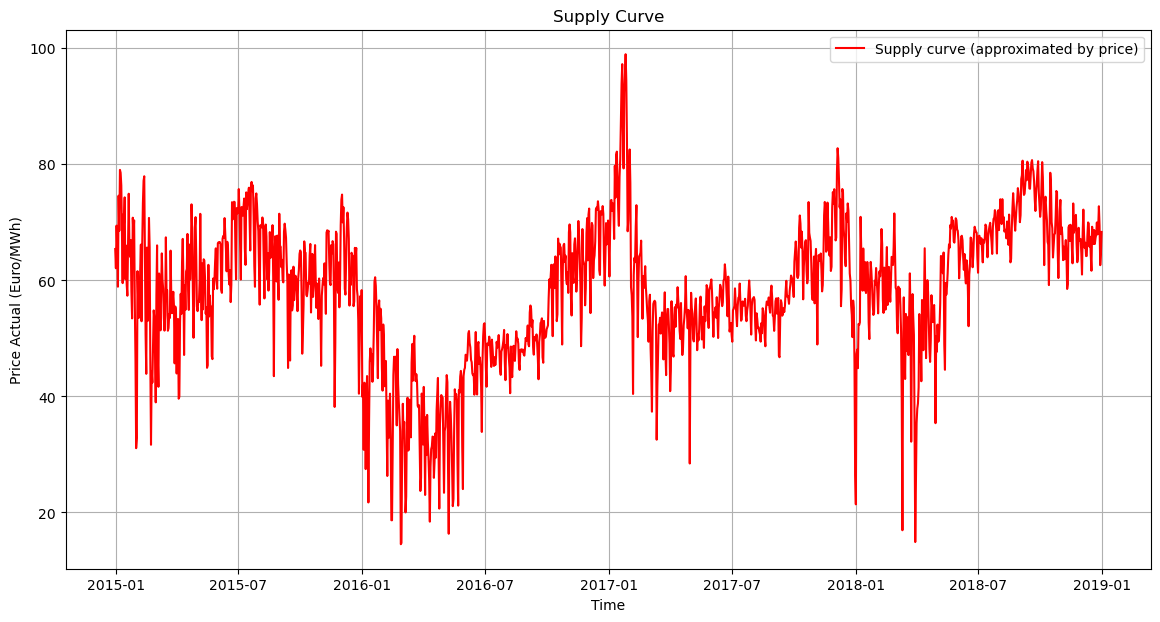

In [16]:
# Create the supply curve plot
plt.figure(figsize=(14, 7))
plt.plot(plot_data_daily.index, plot_data_daily['price actual'], label='Supply curve (approximated by price)', color='red')
plt.title('Supply Curve')
plt.xlabel('Time')
plt.ylabel('Price Actual (Euro/MWh)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Calculate the correlation between each pair of energy and weather features for each city
# List of energy features
energy_features = ['total load actual', 'price actual']

# List of weather features
weather_features = ['temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg']

correlation_results = {}
for city in merged_data['city_name'].unique():
    city_data = merged_data[merged_data['city_name'] == city]
    correlation_results[city] = city_data[energy_features + weather_features].corr().loc[energy_features, weather_features]

# Display the correlation results
correlation_results


{'Valencia':                        temp  pressure  humidity  wind_speed  wind_deg
 total load actual  0.220997  0.010473 -0.313988    0.148194 -0.094123
 price actual       0.090670  0.047952  0.078744   -0.135691 -0.092395,
 'Madrid':                        temp  pressure  humidity  wind_speed  wind_deg
 total load actual  0.172008  0.006828 -0.178369    0.085413 -0.049802
 price actual       0.077580  0.021669 -0.048581   -0.242970 -0.082908,
 'Bilbao':                        temp  pressure  humidity  wind_speed  wind_deg
 total load actual  0.198112 -0.004484 -0.264738    0.154084  0.053713
 price actual       0.070940  0.196766  0.005468   -0.143073 -0.100685,
 ' Barcelona':                        temp  pressure  humidity  wind_speed  wind_deg
 total load actual  0.164338 -0.002215 -0.295955    0.119122 -0.131962
 price actual       0.085422 -0.016393 -0.037195   -0.139398 -0.095592,
 'Seville':                        temp  pressure  humidity  wind_speed  wind_deg
 total load actu

Test MSE: 9883983.977894442


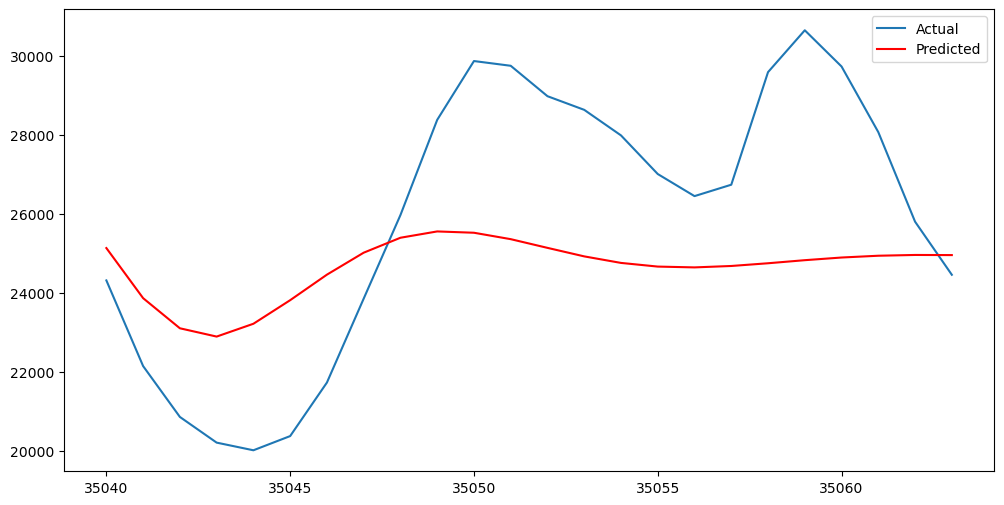

In [18]:
#Basic 24 hour forecast:

# Load the data
data = energy_data

# Use 'total load actual' as the target for forecasting
target = 'total load actual'

# Drop rows with missing target values
data.dropna(subset=[target], inplace=True)

# Split the data into training and test sets (last 24 hours for testing)
train = data[target][:-24]
test = data[target][-24:]

# Define the ARIMA model
model = ARIMA(train, order=(5,1,0))

# Fit the model
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate MSE
mse = mean_squared_error(test, predictions)
print(f'Test MSE: {mse}')

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.legend()
plt.show()

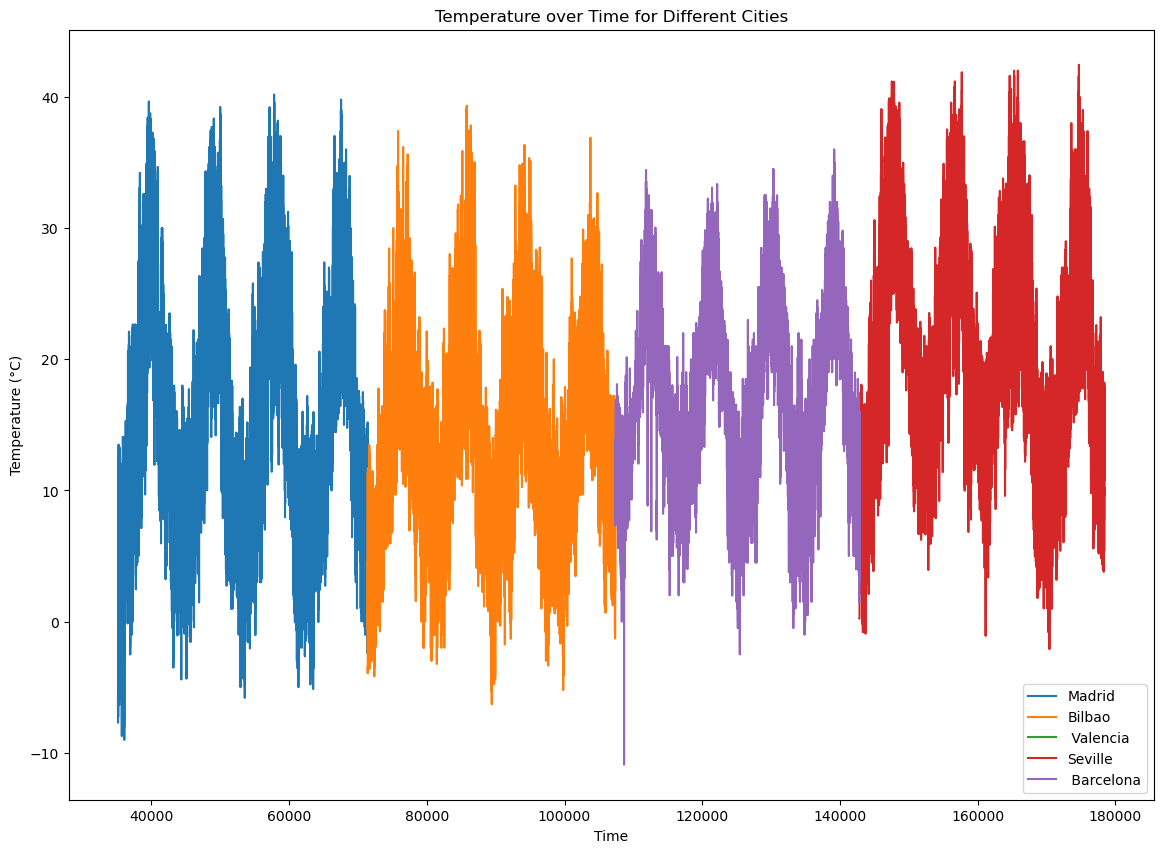

In [19]:
# List of cities in the weather dataset
cities = ['Madrid', 'Bilbao', ' Valencia', 'Seville', ' Barcelona']

# Convert Kelvin to Celsius
for city in cities:
    weather_data.loc[weather_data['city_name'] == city, 'temp'] = weather_data.loc[weather_data['city_name'] == city, 'temp'] - 273.15

plt.figure(figsize=(14,10))

# For each city, plot a line plot of temperature vs. time
for city in cities:
    # Create a new dataframe that only contains rows where weather data is from the current city
    city_data = weather_data[weather_data['city_name'] == city]
    
    # Plot time vs. temperature
    plt.plot(city_data.index, city_data['temp'], label=city)

plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('Temperature over Time for Different Cities')
plt.show()

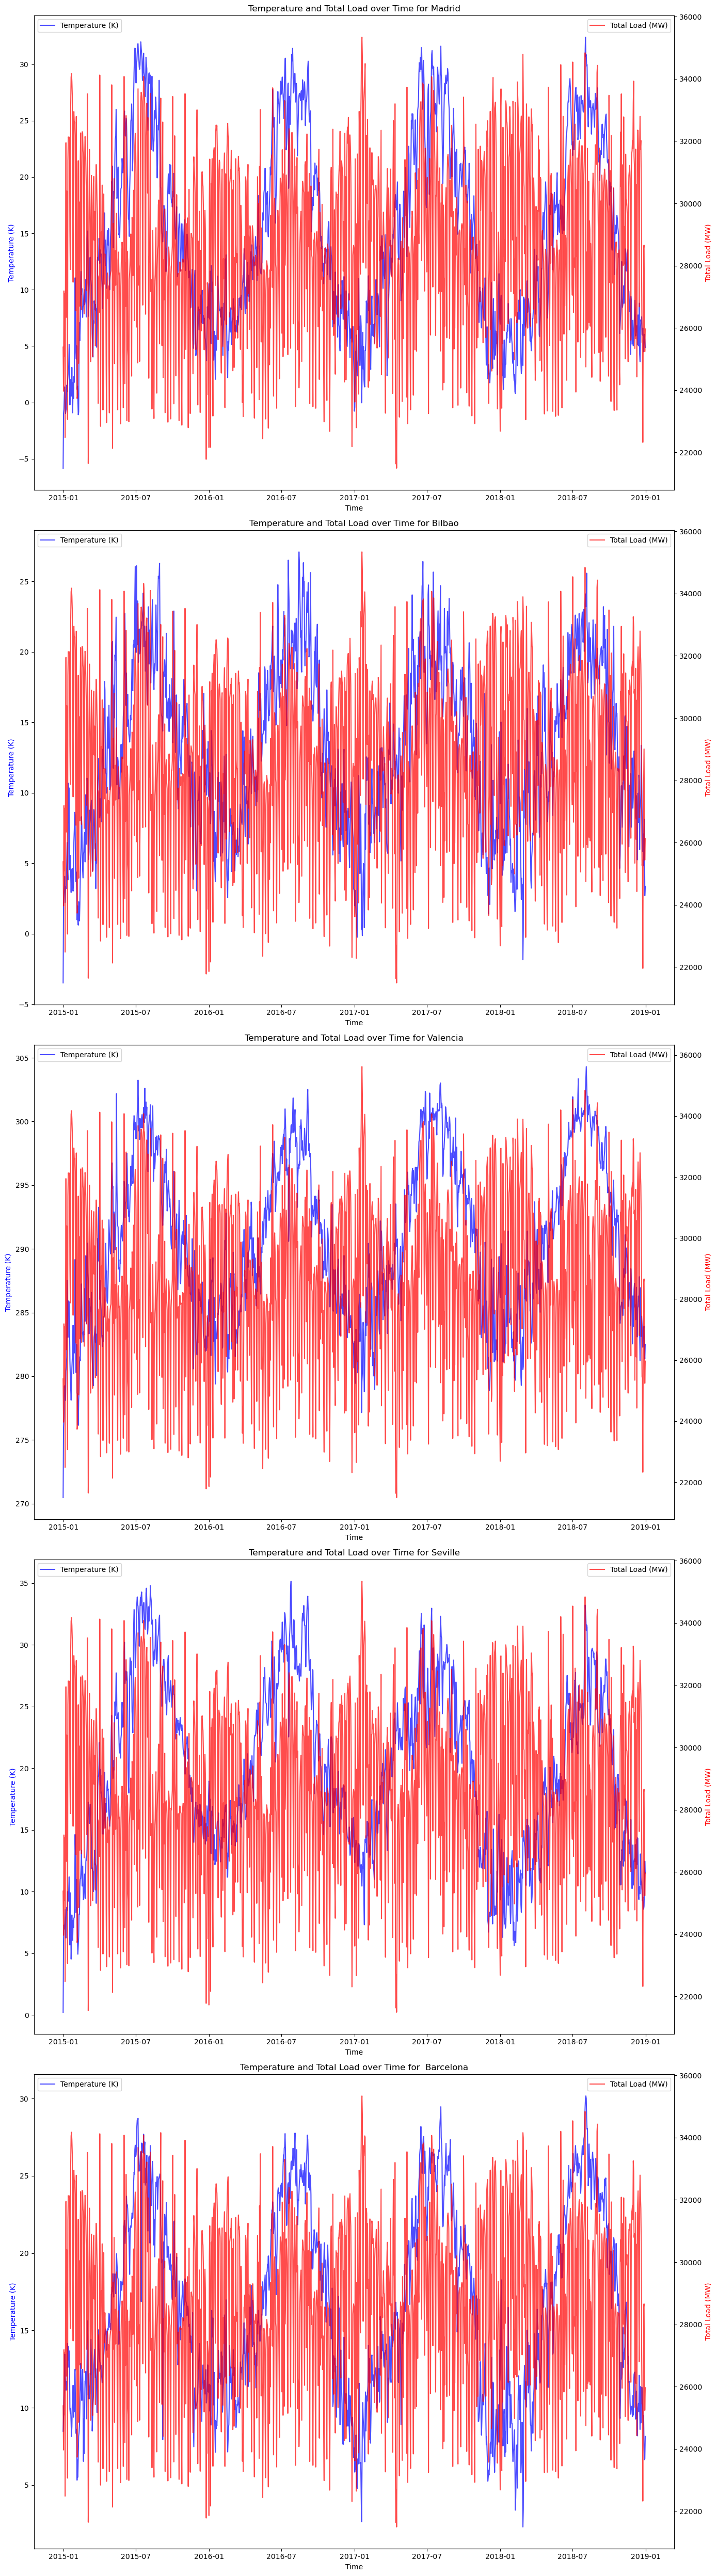

In [20]:
# Convert Kelvin to Celsius
for city in cities:
    merged_data.loc[merged_data['city_name'] == city, 'temp'] = merged_data.loc[merged_data['city_name'] == city, 'temp'] - 273.15

# List of cities in the weather dataset
cities = ['Madrid', 'Bilbao', 'Valencia', 'Seville', ' Barcelona']

fig, axs = plt.subplots(len(cities), 1, figsize=(14, 10 * len(cities)))

# For each city, plot a line plot of temperature vs. time and total load vs. time
for ax, city in zip(axs, cities):
    # Create a new dataframe that only contains rows where weather data is from the current city
    city_data = merged_data[merged_data['city_name'] == city]
    
    # Convert the 'time' column to a datetime object
    city_data = city_data.copy()
    city_data.loc[:, 'time'] = pd.to_datetime(city_data['time'])

    # Set the 'time' column as the index
    city_data.set_index('time', inplace=True)
    
    # Resample the data to a daily frequency
    city_data = city_data.resample('D').mean(numeric_only=True)
    
    # Plot time vs. temperature
    ax.plot(city_data.index, city_data['temp'], color='blue', label='Temperature (K)', alpha=0.7)
    
    # Create a second y-axis for total load
    ax2 = ax.twinx()
    ax2.plot(city_data.index, city_data['total load actual'], color='red', label='Total Load (MW)', alpha=0.7)

    ax.set_xlabel('Time')
    ax.set_ylabel('Temperature (K)', color='blue')
    ax2.set_ylabel('Total Load (MW)', color='red')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.set_title('Temperature and Total Load over Time for ' + city)

plt.tight_layout()
plt.show()